# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/uavsar-main/python").resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,get_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise,)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,get_superpixel_medians_as_features,
                      get_array_from_features)
# # from process_utils import (preprocess_data, 
#                            get_model_labels)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point

In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [4]:
# Path to the folder with the preprocessed images
data_dir = Path("/shared/Wildfire/Jeremiah_Workspace/data")

tifs = sorted(list(data_dir.glob('./*rectangle_preprocessed*.tif')))
tifs

[PosixPath('/shared/Wildfire/Jeremiah_Workspace/data/hv_0_45km_40km_rectangle_preprocessed_interpolated.tif'),
 PosixPath('/shared/Wildfire/Jeremiah_Workspace/data/hv_1_45km_40km_rectangle_preprocessed_interpolated.tif')]

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [5]:
# open the tifs
bands_tv, profiles, transforms = zip(*map(open_one, tifs))
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
profile = profiles[0]
transform = transforms[0]

In [6]:
hv_0 = denoise(hv_0,5)
hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [7]:
# compute log ratio and filter out the vegetation gain by setting to no change.
log_ratio = 10*np.log10(hv_0/hv_1)

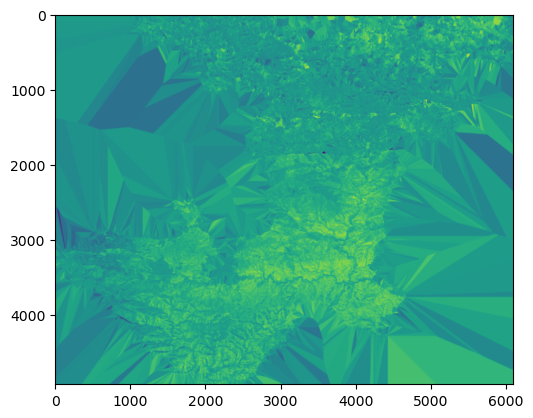

In [8]:
plt.imshow(log_ratio)

In [130]:
# Load if we have performed segmentation previously

superpixel_labels = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/superpixel_labels_230727_231017_min100.npy")
#superpixel_labels = np.load("/shared/Wildfire/Albert_Workspace/Output_Files/superpixel_labels_hv_0&hv_1_min1000.npy")

In [131]:
# # Load if we have performed segmentation previously

# superpixel_labels = np.load("/shared/Wildfire/Jeremiah_Workspace/data/superpixel_labels_230727_231017_min1000.npy")

In [132]:
# # Run this if we do not have the saved np array

# superpixel_labels = superpixel_segmentation(hv_0, hv_1, min_size=100)

# # save this np array to save run time for future runs
# superpixel_out_path = "latuna_bilinear_inc.npy"
# np.save(superpixel_out_path, superpixel_labels)

In [133]:
print("superpizel_labels: ")
print(superpixel_labels)

superpizel_labels: 
[[    0     0     0 ...   378   378   378]
 [    0     0     0 ...   378   378   378]
 [    0     0     0 ...   378   378   378]
 ...
 [42524 42228 42228 ... 43150 43150 43150]
 [42524 42228 42228 ... 43150 43150 43150]
 [42524 42228 42228 ... 43150 43150 43150]]


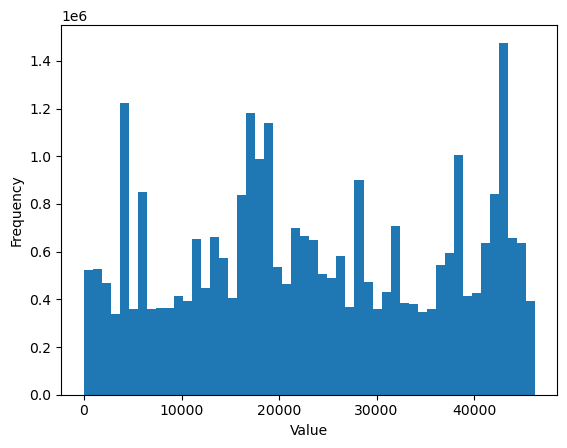

In [134]:
import matplotlib.pyplot as plt

# Check the distribution of the data
plt.hist(superpixel_labels.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Classification

In [135]:
# np.seterr(divide='ignore', invalid='ignore')##
# # Extracting features from the segmentation
# mean_features = get_superpixel_means_as_features(superpixel_labels, log_ratio)
# std_features = get_superpixel_stds_as_features(superpixel_labels, log_ratio)
# print("mean_features", mean_features)
# print("std_features", std_features)

In [136]:
pre_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/pre_merged_alpha1_image_test.npy")
post_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test_aligned.npy")
slope = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Slope/slope_aligned.npy")

In [137]:
print("pre_alpha1", pre_alpha1.shape)

pre_alpha1 (4921, 6093)


In [138]:
print("post_alpha1", post_alpha1.shape)

post_alpha1 (4921, 6093)


In [139]:
print("slope", slope.shape)

slope (4921, 6093)


In [140]:
np.seterr(divide='ignore', invalid='ignore')
#Extracting features
mean_log_ratio = get_superpixel_means_as_features(superpixel_labels, log_ratio)
median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels, pre_alpha1)
median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels, post_alpha1)
diff_alpha1 = median_pre_alpha1 - median_post_alpha1
median_slope = get_superpixel_medians_as_features(superpixel_labels, slope)




In [141]:
unique_superpixel_labels = np.unique(superpixel_labels)
unique_superpixel_labels_reshape = unique_superpixel_labels.reshape(-1,1)

In [142]:
print(unique_superpixel_labels_reshape.shape)

(46223, 1)


In [143]:
print(mean_log_ratio.shape)

(46223, 1)


In [144]:
print(diff_alpha1.shape)

(46223, 1)


In [145]:
print(median_slope.shape)

(46223, 1)


In [146]:
# I need to check how to make a dataframe using these columns
fire_data = np.hstack([unique_superpixel_labels_reshape,mean_log_ratio, diff_alpha1, median_slope])

In [147]:
# unique_vals = np.unique(superpixel_labels)
# print("Unique values in superpixel_labels:", unique_vals)


In [148]:
index = 4
print(f"median_pre_alpha1[{index}] = {median_pre_alpha1[index]}")
print(f"median_post_alpha1[{index}] = {median_post_alpha1[index]}")
print(f"diff_alpha1[{index}] = {diff_alpha1[index]}")
print(f"Manual check: {median_pre_alpha1[index]} - {median_post_alpha1[index]} = {median_pre_alpha1[index] - median_post_alpha1[index]}")


median_pre_alpha1[4] = [nan]
median_post_alpha1[4] = [nan]
diff_alpha1[4] = [nan]
Manual check: [nan] - [nan] = [nan]


In [149]:
unique_vals = np.unique(diff_alpha1)
print("Unique values in diff_alpha1:", unique_vals)

Unique values in diff_alpha1: [-37.64972555 -28.69910174 -24.80038176 ...  47.6989772   48.02899082
          nan]


In [150]:
import pandas as pd
# Create pandas dataframe with column names
df = pd.DataFrame(fire_data, columns=['superpixel_label','mean_log_ratio', 'diff_alpha1', 'median_slope'])
print(df)

       superpixel_label  mean_log_ratio  diff_alpha1  median_slope
0                   0.0        0.153533          NaN           0.0
1                   1.0        0.121117          NaN           0.0
2                   2.0       -0.091186          NaN           0.0
3                   3.0       -0.320150          NaN           0.0
4                   4.0       -0.510882          NaN           0.0
...                 ...             ...          ...           ...
46218           46218.0        4.110041          NaN           0.0
46219           46219.0        3.877449          NaN           0.0
46220           46220.0        3.527726          NaN           0.0
46221           46221.0        4.494373          NaN           0.0
46222           46222.0        1.351155          NaN           0.0

[46223 rows x 4 columns]


In [151]:
# Calculate the number of non-null values in each row
non_null_counts = df.count(axis=1)

# Get the total number of columns
num_columns = df.shape[1]

# Determine complete rows
complete_rows = df[non_null_counts == num_columns]

# Count the number of complete rows
num_complete_rows = len(complete_rows)
print(num_complete_rows)

25723


In [152]:
# retain only complete rows
df_cleaned = df.dropna()
print(len(df_cleaned))
#pd.set_option('display.max_rows',None)
print(df_cleaned)

25723
       superpixel_label  mean_log_ratio  diff_alpha1  median_slope
20                 20.0       -0.229221     3.638625        1397.0
21                 21.0       -0.471119     3.916022        1456.0
22                 22.0       -0.198741     3.103318        1467.0
23                 23.0        0.428679     2.646119        1439.0
24                 24.0       -0.696495     0.243206        1424.0
...                 ...             ...          ...           ...
46150           46150.0        4.537420     3.377002         456.0
46164           46164.0        3.965630     3.018221         402.0
46165           46165.0        2.093484     5.571453         401.0
46170           46170.0        4.007327    10.247247         438.0
46176           46176.0        4.583709    15.527438         430.0

[25723 rows x 4 columns]


In [153]:
df_cleaned_for_model = df_cleaned.drop('superpixel_label', axis=1) # we don't want to use the superpixel label as a feature
print(df_cleaned_for_model)

       mean_log_ratio  diff_alpha1  median_slope
20          -0.229221     3.638625        1397.0
21          -0.471119     3.916022        1456.0
22          -0.198741     3.103318        1467.0
23           0.428679     2.646119        1439.0
24          -0.696495     0.243206        1424.0
...               ...          ...           ...
46150        4.537420     3.377002         456.0
46164        3.965630     3.018221         402.0
46165        2.093484     5.571453         401.0
46170        4.007327    10.247247         438.0
46176        4.583709    15.527438         430.0

[25723 rows x 3 columns]


In [154]:
# from sklearn.cluster import KMeans
# model = KMeans(n_clusters=4, ##3
#               n_init=10,
#               random_state=1)
# classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = classes + 1
# classes

Other Hyperparameter Values for K-means

In [155]:
# from sklearn.cluster import KMeans

# model = KMeans(
#     n_clusters=4,
#     init='k-means++',
#     n_init=10,
#     max_iter=300,
#     tol=1e-4,
#     algorithm='elkan',
#     random_state=42
# )
# classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = classes + 1
# classes

In [156]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(df_cleaned_for_model)  # Replace with your actual data variable
distances, indices = neighbors_fit.kneighbors(df_cleaned_for_model)

distances = np.sort(distances, axis = 0)



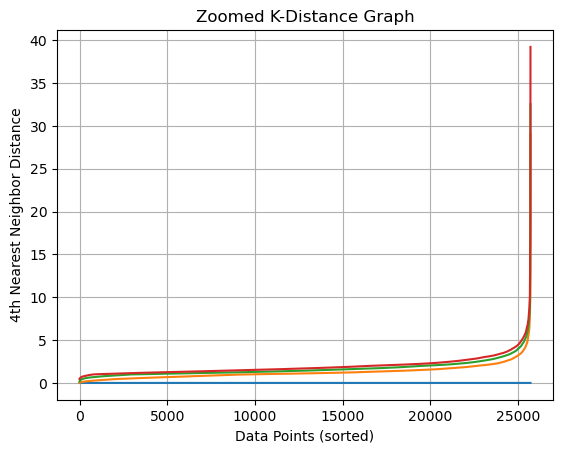

In [157]:
plt.plot(distances[4:])
plt.ylabel("4th Nearest Neighbor Distance")
plt.xlabel("Data Points (sorted)")
plt.title("Zoomed K-Distance Graph")
plt.grid(True)
plt.show()

In [158]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from kneed import KneeLocator  # install via pip install kneed

# Fit Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(df_cleaned_for_model)
distances, indices = neighbors_fit.kneighbors(df_cleaned_for_model)

# Sort the 4th nearest distances
distances = np.sort(distances[:, 3])  # 4th column (0-indexed)

# Find the knee (elbow) point
kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[kneedle.knee]

print(f"Optimal eps based on knee method: {optimal_eps:.4f}")


Optimal eps based on knee method: 6.7039


DBSCAN

In [159]:
# from sklearn.cluster import DBSCAN
# # from sklearn.preprocessing import StandardScaler

# # # Step 1: Scale the data
# # scaler = StandardScaler()
# # scaled_data = scaler.fit_transform(df_cleaned_for_model)

# # Step 2: Apply DBSCAN with tuned parameters
# model = DBSCAN(eps=13, min_samples=4, metric='euclidean', algorithm='auto', n_jobs=-1)
# classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = classes + 1
# classes



In [160]:
# import hdbscan


# # Assuming you've already scaled your data
# # scaled_data = StandardScaler().fit_transform(df_cleaned_for_model)

# model = hdbscan.HDBSCAN(
#     min_cluster_size=5,     # Minimum size of clusters
#     min_samples=5,          # Controls sensitivity to noise
#     metric='euclidean',     # Or try 'manhattan', 'canberra', etc.
#     cluster_selection_method='eom'  # Or 'leaf'
# )

# # labels = model.fit_predict(scaled_data)
# # print("Unique labels:", np.unique(labels))
# classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = classes + 1
# classes

In [161]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler


# Step 1: Remove NaNs
mask = np.isnan(df_cleaned_for_model).any(axis=1)
masked_data = df_cleaned_for_model[~mask]

# Step 2: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(masked_data)

# Step 3: Use updated parameter `metric` instead of `affinity`
model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')


classes = get_superpixel_model_labels(masked_data, model)
classes = classes 
classes

array([3, 3, 3, ..., 2, 2, 2])

In [162]:
print(np.unique(classes))

[0 1 2 3]


In [163]:
# from sklearn.cluster import OPTICS
# from sklearn.preprocessing import StandardScaler


# # # Step 1: Scale the data
# # scaler = StandardScaler()
# # scaled_data = scaler.fit_transform(df_cleaned_for_model)

# # Step 2: OPTICS
# model = OPTICS(min_samples=4, metric='minkowski', cluster_method='xi', xi=0.05)  # xi controls cluster sensitivity
# classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = classes + 1
# classes


In [164]:
# print(len(classes))

print(df_cleaned.shape)

(25723, 4)


In [165]:
# # Dr.Uma Code
# model_output = superpixel_labels
# # model_output = np.empty_like(superpixel_labels)
# # model_output[:] = 0 # 0 indicates missing values since classes are numbered 1, 2, ...

# for i in range(len(classes)):
#     # print(i)
#     # print(df_cleaned.iat[i,0])
#     # print(classes[i])
#     model_output[model_output==int(df_cleaned.iat[i,0])] = classes[i]
#     # model_output = np.where(model_output == int(df_cleaned.iat[i,0]),classes[i],0) # logically this is correct
#     # np.put(model_output,np.where(model_output==int(df_cleaned.iat[i,0])),classes[i])
#     # model_output.replace(df_cleaned.iat[i,0],classes[i])
# # print(superpixel_labels)
# # print(model_output)

In [166]:
# # Start with all background as 0
# model_output = np.zeros_like(superpixel_labels)

# # Replace superpixel IDs with cluster class (0 or 1)
# for i in range(len(classes)):
#     label_id = int(df_cleaned.iat[i, 0])
#     cluster_class = classes[i]
#     model_output[superpixel_labels == label_id] = cluster_class   # Optional: +1 to match Burned=1, Unburned=2

In [167]:
# Start with all 0s (background)
model_output = np.zeros_like(superpixel_labels)

# Replace superpixel labels with cluster class (0 or 1)
# Then +1 to shift classes to 1 and 2 (for visualization)
for i in range(len(classes)):
    label = int(df_cleaned.iat[i, 0])    # superpixel ID
    cls = int(classes[i]) + 1            # 1 or 2
    model_output[superpixel_labels == label] = cls

In [168]:
print(model_output)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [169]:
print(np.unique(model_output))

[0 1 2 3 4]


In [170]:
#print(np.unique(model_output))
print(type(model_output))

<class 'numpy.ndarray'>


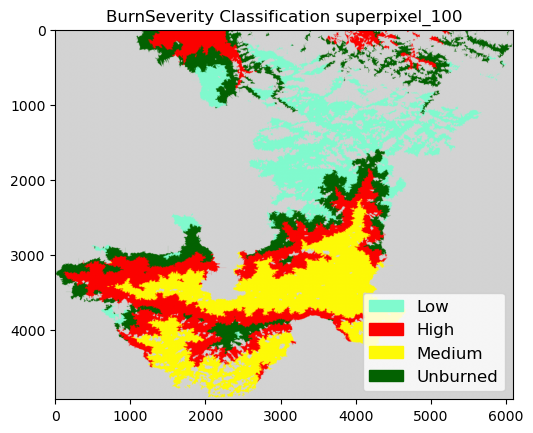

In [173]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
colors = ['lightgray'] * 10  # A default color for other values
colors[1] = '#80face'
colors[2] = '#fc0200'
colors[3] = '#fefa07'
colors[4] = '#036201'

class_names = {
    1: "Low",
    2: "High",
    3: "Medium",
    4: "Unburned"
}

cmap = mcolors.ListedColormap(colors)

bounds = np.arange(len(colors) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

legend_patches = [
    mpatches.Patch(color=colors[i], label=class_names[i]) for i in class_names
]

plt.imshow(model_output, cmap=cmap, norm=norm)
#plt.colorbar(ticks=np.arange(len(colors))) # Add a colorbar for reference
plt.title('BurnSeverity Classification superpixel_100')
plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()

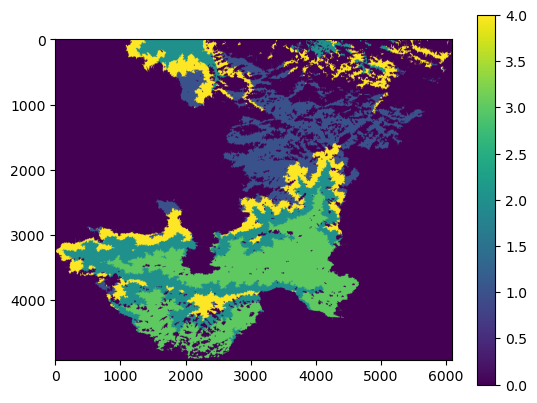

In [174]:
plt.imshow(model_output)
plt.colorbar()